In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۲ — مبانی داده و پیش‌پردازش
## درس ۷: نشت داده (Data Leakage) و تکنیک‌های پیشگیری

### چرا این درس مهم است؟

نشت داده یکی از سریع‌ترین راه‌ها برای این است که یک پروژهٔ یادگیری ماشین در نوت‌بوک عالی به نظر برسد اما در دنیای واقعی (پروداکشن) شکست بخورد. نشت زمانی رخ می‌دهد که اطلاعاتی که **در زمان پیش‌بینی در دسترس نیست** (یا اطلاعاتی که «متعلق به مجموعهٔ آزمون» است) به‌صورت ناخواسته وارد فرایند آموزش شود. نتیجه معمولاً **امتیازهای بیش از حد خوش‌بینانه**، انتخاب مدل اشتباه و استقرار شکننده است.

این درس کاملاً عملی است: عمداً پایپلاین‌های نشت‌دار می‌سازیم، امتیازهای غیرواقعی را مشاهده می‌کنیم و سپس با انتخاب درستِ روش تقسیم داده و استفاده از `Pipeline` آن را اصلاح می‌کنیم.

### اهداف یادگیری

در پایان این درس شما قادر خواهید بود:

1. نشت داده را دقیق تعریف کنید و توضیح دهید چرا تعمیم (generalization) را خراب می‌کند.
2. خانواده‌های اصلی نشت را تشخیص دهید:
   - **نشت هدف** (ویژگی‌های پس از رخداد/پس از نتیجه)
   - **آلودگی آموزش/آزمون** (داده‌های تکراری، هم‌پوشانی موجودیت‌ها، استفادهٔ مجدد از برچسب)
   - **نشت در پیش‌پردازش** (فیت کردن اسکیلر/انکودر/انتخاب ویژگی روی کل داده)
   - **نشت زمانی** (استفاده از اطلاعات آینده در داده‌های زمان‌مند)
   - **نشت گروهی/موجودیتی** (حضور یک مشتری/هاست/بیمار در آموزش و آزمون)
   - **نشت انتخاب مدل** (تنظیم ابرپارامترها با نگاه به تست)
3. جریان‌های کاری امن در برابر نشت را با ابزارهای زیر پیاده‌سازی کنید:
   - `Pipeline` و `ColumnTransformer`
   - `GroupKFold`، تقسیم مبتنی بر زمان و الگوهای Nested CV
4. «فورنزیک نشت» را انجام دهید: بررسی‌های sanity که نشت را زود کشف می‌کنند.

### ایدهٔ کلیدی در یک جمله

ارزیابی مدل تنها زمانی معتبر است که دادهٔ ارزیابی را مانند **اطلاعات کاملاً نادیده و آینده** در نظر بگیریم.

## ۱) نشت داده چیست؟

فرض کنید داده شامل زوج‌های $(x_i, y_i)$ است که $x_i$ ویژگی‌ها و $y_i$ هدف است. ما می‌خواهیم تخمینی معتبر از عملکرد مدل $f_\theta$ روی دادهٔ جدید داشته باشیم.

نمایی ساده از آموزش:

$$
\hat{\theta} = \arg\min_\theta \frac{1}{n}\sum_{i=1}^n \ell\big(y_i, f_\theta(x_i)\big).
$$

نمایی ساده از ارزیابی (برآورد ریسک):

$$
\hat{R} = \frac{1}{m}\sum_{j=1}^m \ell\big(y^{(test)}_j, f_{\hat{\theta}}(x^{(test)}_j)\big).
$$

نشت زمانی رخ می‌دهد که اطلاعاتی از مجموعهٔ آزمون (یا اطلاعاتی که به نوعی وابسته به $y$ است و در زمان پیش‌بینی در دسترس نیست) روی یکی از موارد زیر اثر بگذارد:

- پارامترهای یادگرفته‌شده $\hat{\theta}$ (نشت در آموزش)، یا
- انتخاب ابرپارامتر/کلاس مدل (نشت در انتخاب)، یا
- ساخت ویژگی‌ها و مهندسی ویژگی (نشت در ویژگی‌سازی).

### تعریف عملی

اگر فرایندی که ویژگی‌های آموزش را می‌سازد از اطلاعاتی استفاده کند که باید در زمان آموزش «نامعلوم» باشد، نشت داریم.

به‌صورت معادل:

- اگر ویژگی از داده‌های «آینده» یا «پس از رخداد» استفاده کند، نشت هدف است.
- اگر یک موجودیت واقعی (مثلاً یک مشتری) در آموزش و آزمون تکرار شود، ممکن است عملکرد اندازه‌گیری‌شده بیشتر «حافظه» باشد تا «تعمیم».
- اگر یک تبدیل آماری روی کل داده (شامل تست) فیت شود، توزیع تست به آموزش نشت کرده است.

### چرا نشت امتیازها را بالا می‌برد؟

نشت عملاً اطلاعات متقابل بین ویژگی‌ها و هدف را به شکل غیرواقعی افزایش می‌دهد. اگر یک ویژگی به‌طور مستقیم یا غیرمستقیم $y$ را کد کند، مدل می‌تواند «تقلب» کند. این تقلب در استقرار از بین می‌رود، چون آن ویژگی واقعاً در دسترس نیست یا پایدار نیست.

### دو سؤال همیشگی

1. **آیا این ویژگی در زمان پیش‌بینی وجود دارد؟** (در دسترس بودن عملیاتی)
2. **آیا این تبدیل فقط با دادهٔ آموزش فیت شده است؟** (بهداشت جریان کاری)

## ۲) گونه‌شناسی نشت و علت‌های رایج

### ۲.۱ نشت هدف (ویژگی‌های پس از نتیجه)

نمونه‌ها:
- در دادهٔ پزشکی، «پلن درمان» پس از تشخیص ثبت می‌شود.
- در دادهٔ وام، «ماه‌های معوق» پس از نکول محاسبه می‌شود.
- در دادهٔ مشتری، «ترک سرویس ماه قبل» برای پیش‌بینی ترک سرویس استفاده می‌شود.

نشانه: امتیازهای نزدیک به کامل که «بیش از حد خوب» به نظر می‌رسند.

### ۲.۲ آلودگی آموزش/آزمون

نمونه‌ها:
- ردیف‌های تکراری بین تقسیم‌ها
- تجمیع‌هایی که با استفاده از کل داده محاسبه شده‌اند (مثلاً میانگین هدف برحسب دسته روی همهٔ ردیف‌ها)
- حضور داده‌های یک فرد/موجودیت در آموزش و آزمون (نشت موجودیتی)

نشانه: عملکردی که روی دادهٔ بیرونی واقعی فرو می‌ریزد.

### ۲.۳ نشت پیش‌پردازش

نمونه‌ها:
- استانداردسازی با میانگین/انحراف معیار کل داده پیش از تقسیم
- وان-هات انکودینگ پس از دیدن دسته‌های تست
- انتخاب ویژگی پیش از اعتبارسنجی متقاطع

نشانه: بهبود «مرموز» امتیازها بعد از پیش‌پردازش سنگین.

### ۲.۴ نشت زمانی

نمونه‌ها:
- تقسیم تصادفی روی دادهٔ زمان‌مند (آینده وارد آموزش می‌شود)
- ویژگی‌هایی که آینده را شامل می‌شوند (مثل «فروش هفتهٔ بعد»)
- پنجره‌های رولینگ که به جلو نگاه می‌کنند

نشانه: بک‌تست عالی اما عملکرد ضعیف رو به جلو.

### ۲.۵ نشت گروهی/موجودیتی

نمونه‌ها:
- یک `customer_id` در آموزش و آزمون
- یک `host_id` در تقسیم‌های مختلف
- یک بیمار با چند ویزیت در آموزش و آزمون

نشانه: مدل ظاهراً قوی است اما در واقع الگوهای ثابتِ مربوط به ID را حفظ می‌کند.

### ۲.۶ نشت انتخاب مدل

نمونه‌ها:
- ارزیابی مکرر روی تست هنگام تنظیم ابرپارامترها
- مقایسهٔ مدل‌های متعدد و انتخاب بهترین بر اساس تست

نشانه: تست تبدیل به ولیدیشن می‌شود و دیگر تعمیم را اندازه نمی‌گیرد.

در آزمایش‌های کدنویسی زیر، هر کدام از این الگوها و اصلاح آن را خواهید دید.

## ۳) آماده‌سازی

در این درس برای نشان دادن انواع نشت از چند دیتاست موجود در مخزن استفاده می‌کنیم:

- **طبقه‌بندی**: `diabetes.csv` (هدف دودویی)
- **رگرسیون**: `house-prices.csv` (هدف پیوسته)
- **زمان + گروه**: `listings.csv` (ستون زمان + `host_id`)
- **متن + نشت هدف**: `ConsumerComplaints.csv`
- **نشت انتخاب ویژگی**: `Wine_Quality.csv`

نکتهٔ مهم این است که نشت وابسته به دیتاست نیست؛ مشکل اصلی «اشتباه در جریان کاری» است.

In [2]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, GroupKFold, cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(7)

def show_df(name, df, n=5):
    print(f"{name}: ابعاد={df.shape}")
    display(df.head(n))

In [3]:
# بارگذاری دیتاست‌ها با مسیرهای نسبی مخزن (از محل این نوت‌بوک):
# Tutorials/Persian/Chapter2/Chapter2_Lesson7_Fa.ipynb  -> ../../../Datasets/...

base = Path("../../../")

paths = {
    "diabetes": base / "Datasets/Classification/diabetes.csv",
    "house": base / "Datasets/Regression/house-prices.csv",
    "listings": base / "Datasets/Regression/listings.csv",
    "complaints": base / "Datasets/Clustering/ConsumerComplaints.csv",
    "wine": base / "Datasets/Classification/Wine_Quality.csv",
}

diabetes = pd.read_csv(paths["diabetes"])
house = pd.read_csv(paths["house"])
listings = pd.read_csv(paths["listings"])
complaints = pd.read_csv(
    paths["complaints"],
    low_memory=False,
    dtype={
        "Consumer Complaint Narrative": "string",
        "Consumer Consent Provided": "string",
    }
)
wine = pd.read_csv(paths["wine"])

show_df("diabetes", diabetes)
show_df("house-prices", house)
show_df("listings", listings)
show_df("ConsumerComplaints", complaints)
show_df("Wine_Quality", wine)

diabetes: ابعاد=(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


house-prices: ابعاد=(128, 8)


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


listings: ابعاد=(94559, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,57.0,1,51,2025-02-09,0.29,3,344,10,NaN
1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48780,-0.16813,Entire home/apt,NaN,4,96,2024-04-28,0.52,1,11,2,NaN
2,17402,Very Central Modern 3-Bed/2 Bath By Oxford St W1,67564,Liz,NaN,Westminster,51.52195,-0.14094,Entire home/apt,510.0,3,56,2024-02-19,0.33,5,293,0,NaN
3,24328,Battersea live/work artist house,41759,Joe,NaN,Wandsworth,51.47072,-0.16266,Entire home/apt,213.0,90,94,2022-07-19,0.54,1,194,0,NaN
4,31036,Bright compact 1 Bedroom Apartment Brick Lane,133271,Hendryks,NaN,Tower Hamlets,51.52425,-0.06997,Entire home/apt,100.0,2,126,2025-02-20,0.70,8,353,3,NaN


ConsumerComplaints: ابعاد=(65499, 18)


,Date Received,Product Name,Sub Product,Issue,Sub Issue,Consumer Complaint Narrative,Company Public Response,Company,State Name,Zip Code,Tags,Consumer Consent Provided,Submitted via,Date Sent to Company,Company Response to Consumer,Timely Response,Consumer Disputed,Complaint ID
0,2013-07-29,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,<NA>,NaN,Wells Fargo & Company,VA,24540,NaN,<NA>,Phone,2013-07-30,Closed with explanation,Yes,No,468882
1,2013-07-29,Bank account or service,Checking account,Using a debit or ATM card,NaN,<NA>,NaN,Wells Fargo & Company,CA,95992,Older American,<NA>,Web,2013-07-31,Closed with explanation,Yes,No,468889
2,2013-07-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,<NA>,NaN,Santander Bank US,NY,10065,NaN,<NA>,Fax,2013-07-31,Closed,Yes,No,468879
3,2013-07-29,Bank account or service,Checking account,Deposits and withdrawals,NaN,<NA>,NaN,Wells Fargo & Company,GA,30084,NaN,<NA>,Web,2013-07-30,Closed with explanation,Yes,No,468949
4,2013-07-29,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,<NA>,NaN,Franklin Credit Management,CT,6106,NaN,<NA>,Web,2013-07-30,Closed with explanation,Yes,No,475823


Wine_Quality: ابعاد=(4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## ۴) آزمایش A — نشت هدف (ویژگی‌های پس از رخداد)

یک اشتباه کلاسیک را شبیه‌سازی می‌کنیم: اضافه کردن ویژگی‌ای که با استفاده از برچسب واقعی ساخته شده است (حتی به‌صورت غیرمستقیم).

فرض کنید می‌خواهیم وضعیت دیابت را پیش‌بینی کنیم. یک ویژگی نشت‌دار می‌تواند چیزی شبیه موارد زیر باشد:

- «کد تشخیص» که **بعد از** تشخیص تولید می‌شود
- «شدت/نوع برنامهٔ درمان»
- «تعداد مراجعات پیگیری»

این‌ها به‌شدت با هدف هم‌بسته‌اند چون پیامدهای هدف هستند.

### انتظار چه چیزی داریم؟

- با ویژگی نشت‌دار، دقت می‌تواند به شکل غیرواقعی بالا برود.
- با حذف نشت، عملکرد به مقدار منطقی‌تری کاهش می‌یابد.

دقت اعتبارسنجی متقاطع با نشت هدف:
[1. 1. 1. 1. 1.]
میانگین دقت: 1.0

دقت روی دادهٔ جدا (نشت‌دار): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       125
           1      1.000     1.000     1.000        67

    accuracy                          1.000       192
   macro avg      1.000     1.000     1.000       192
weighted avg      1.000     1.000     1.000       192



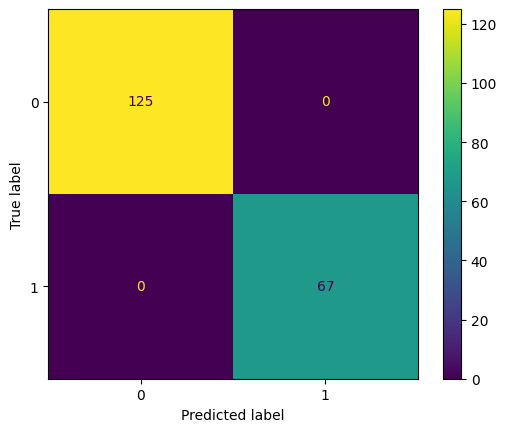

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df = diabetes.copy()

# هدف دودویی
y = (df["classification"] == "Diabetic").astype(int)

X = df.drop(columns=["classification"])

# ساخت یک ویژگی عمداً نشت‌دار: کپیِ نویزی از هدف
rng = np.random.default_rng(7)
X_leaky = X.copy()
X_leaky["post_diagnosis_flag"] = y + rng.normal(0, 0.05, size=len(y))  # تقریباً هدف را کد می‌کند

numeric_features = X.columns.tolist() + ["post_diagnosis_flag"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

scores_leaky = cross_val_score(pipe, X_leaky[numeric_features], y, cv=5, scoring="accuracy")
print("دقت اعتبارسنجی متقاطع با نشت هدف:")
print(scores_leaky)
print("میانگین دقت:", scores_leaky.mean().round(4))

# ارزیابی روی یک تقسیم جدا برای نمایش اثر مشابه
X_train, X_test, y_train, y_test = train_test_split(
    X_leaky[numeric_features], y, test_size=0.25, random_state=7, stratify=y
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("\nدقت روی دادهٔ جدا (نشت‌دار):", round(accuracy_score(y_test, pred), 4))
print(classification_report(y_test, pred, digits=3))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### اصلاح: حذف ویژگی‌های پس از رخداد

از نظر مفهومی اصلاح ساده است: هر ویژگی‌ای که *قبل از* رخداد قابل دسترسی نیست باید حذف شود. در عمل لازم است این موضوع با «حاکمیت داده» پشتیبانی شود:

- تعریف ویژگی‌ها همراه با زمان («در دسترس از چه زمانی»)
- ساخت ویژگی‌ها با رعایت cutoff time
- بررسی lineage برای جلوگیری از join به جداولی که بعد از رخداد پر می‌شوند

اکنون ستون نشت‌دار را حذف می‌کنیم و دوباره ارزیابی می‌کنیم.

In [5]:
X_clean = X.copy()
numeric_features_clean = X_clean.columns.tolist()

scores_clean = cross_val_score(pipe, X_clean[numeric_features_clean], y, cv=5, scoring="accuracy")
print("دقت اعتبارسنجی متقاطع بدون ویژگی نشت‌دار:")
print(scores_clean)
print("میانگین دقت:", scores_clean.mean().round(4))

X_train, X_test, y_train, y_test = train_test_split(
    X_clean[numeric_features_clean], y, test_size=0.25, random_state=7, stratify=y
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("\nدقت روی دادهٔ جدا (پاک):", round(accuracy_score(y_test, pred), 4))
print(classification_report(y_test, pred, digits=3))

دقت اعتبارسنجی متقاطع بدون ویژگی نشت‌دار:
[0.77272727 0.74675325 0.75324675 0.81699346 0.76470588]
میانگین دقت: 0.7709

دقت روی دادهٔ جدا (پاک): 0.7812
              precision    recall  f1-score   support

           0      0.799     0.888     0.841       125
           1      0.736     0.582     0.650        67

    accuracy                          0.781       192
   macro avg      0.767     0.735     0.745       192
weighted avg      0.777     0.781     0.774       192



## ۵) آزمایش B — نشت پیش‌پردازش (فیت روی کل داده در برابر فیت روی آموزش)

یکی از رایج‌ترین نشت‌ها این است که مراحل پیش‌پردازش را قبل از تقسیم داده و روی کل دیتاست فیت کنیم:

- `StandardScaler().fit(X)` روی همهٔ ردیف‌ها
- `OneHotEncoder().fit(X)` روی همهٔ ردیف‌ها
- `SimpleImputer().fit(X)` روی همهٔ ردیف‌ها

در این حالت آمارهای تست (میانگین‌ها، دسته‌ها، فراوانی‌ها) روی تبدیل اثر می‌گذارند و ارزیابی خوش‌بینانه می‌شود.

الگوی درست: قرار دادن تمام پیش‌پردازش‌ها داخل `Pipeline` و فیت شدن آن فقط روی دادهٔ آموزش (یا هر فولد آموزش در CV).

In [6]:
df = house.copy()

y = df["Price"].astype(float)
X = df.drop(columns=["Price"])

num_cols = ["SqFt", "Bedrooms", "Bathrooms", "Offers"]
cat_cols = ["Brick", "Neighborhood"]

# -------------------------
# بد: فیت پیش‌پردازش روی کل داده (نشت)
# -------------------------
X_full = X.copy()

imp_num = SimpleImputer(strategy="median").fit(X_full[num_cols])
imp_cat = SimpleImputer(strategy="most_frequent").fit(X_full[cat_cols])

X_num_imp = pd.DataFrame(imp_num.transform(X_full[num_cols]), columns=num_cols)
X_cat_imp = pd.DataFrame(imp_cat.transform(X_full[cat_cols]), columns=cat_cols)

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit(X_cat_imp)
X_cat_ohe = pd.DataFrame(ohe.transform(X_cat_imp), columns=ohe.get_feature_names_out(cat_cols))

scaler = StandardScaler().fit(X_num_imp)
X_num_scaled = pd.DataFrame(scaler.transform(X_num_imp), columns=num_cols)

X_leaky = pd.concat([X_num_scaled, X_cat_ohe], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_leaky, y, test_size=0.25, random_state=7)

model = Ridge(alpha=10.0)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("پیش‌پردازش نشت‌دار (فیت روی کل داده) => R2:", round(r2_score(y_test, pred), 4),
      " MAE:", round(mean_absolute_error(y_test, pred), 1))

# -------------------------
# خوب: پایپلاین (بدون نشت)
# -------------------------
preprocess = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

pipe = Pipeline([
    ("prep", preprocess),
    ("model", Ridge(alpha=10.0))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("پایپلاین (فیت فقط روی آموزش)         => R2:", round(r2_score(y_test, pred), 4),
      " MAE:", round(mean_absolute_error(y_test, pred), 1))

پیش‌پردازش نشت‌دار (فیت روی کل داده) => R2: 0.8703  MAE: 6856.1
پایپلاین (فیت فقط روی آموزش)         => R2: 0.8696  MAE: 6868.2


## ۶) آزمایش C — نشت انتخاب ویژگی (انتخاب قبل از CV)

انتخاب ویژگی می‌تواند وقتی نشت ایجاد کند که با استفاده از کل داده (یا فولد تست) قبل از اعتبارسنجی متقاطع انجام شود.

الگوی نشت‌دار:

1. محاسبهٔ امتیاز ویژگی‌ها با استفاده از همهٔ ردیف‌ها (شامل فولدهای تست)
2. انتخاب top-$k$ ویژگی
3. اعتبارسنجی متقاطع مدل روی دادهٔ انتخاب‌شده

این کار نامعتبر است چون مرحلهٔ (۱) به فولدهای تست نگاه کرده است.

### الگوی درست

انتخاب ویژگی باید داخل `Pipeline` باشد تا در هر فولد، فقط روی دادهٔ آموزش فیت شود.

In [7]:
df = wine.copy()

# تعریف هدف دودویی: «کیفیت بالا»
y = (df["quality"] >= 7).astype(int)
X = df.drop(columns=["quality"])

# بد: انتخاب ویژگی روی کل داده
selector = SelectKBest(score_func=f_classif, k=5).fit(X, y)
X_selected_leaky = selector.transform(X)

clf = LogisticRegression(max_iter=2000)
scores_leaky = cross_val_score(clf, X_selected_leaky, y, cv=5, scoring="accuracy")
print("انتخاب ویژگی نشت‌دار => دقت CV:", scores_leaky.mean().round(4))
print("ویژگی‌های انتخاب‌شده:", X.columns[selector.get_support()].tolist())

# خوب: انتخاب درون پایپلاین
pipe = Pipeline([
    ("selector", SelectKBest(score_func=f_classif, k=5)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

scores_clean = cross_val_score(pipe, X, y, cv=5, scoring="accuracy")
print("انتخاب ویژگی در پایپلاین => دقت CV:", scores_clean.mean().round(4))

انتخاب ویژگی نشت‌دار => دقت CV: 0.7893
ویژگی‌های انتخاب‌شده: ['residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'alcohol']
انتخاب ویژگی در پایپلاین => دقت CV: 0.7934


انتخاب ویژگی در پایپلاین => دقت CV: 0.7825


## ۷) آزمایش D — نشت زمانی (تقسیم تصادفی در برابر تقسیم رو به جلو)

وقتی داده محور زمانی دارد، تقسیم تصادفی باعث می‌شود مدل «آینده» را ببیند. اگر روند، فصل‌مندی یا drift وجود داشته باشد، ارزیابی بسیار خوش‌بینانه خواهد شد.

ما قیمت آگهی را با استفاده از ویژگی‌هایی که در زمان آگهی قابل دسترس‌اند پیش‌بینی می‌کنیم و دو حالت را مقایسه می‌کنیم:

- **تقسیم تصادفی** (برای مسائل زمانی معمولاً نشت‌دار)
- **تقسیم رو به جلو**: آموزش روی تاریخ‌های قدیمی‌تر و آزمون روی تاریخ‌های جدیدتر (شبیه شرایط استقرار)

ارزیابی معتبر برای دادهٔ زمانی معمولاً شبیه این است: «آموزش روی گذشته، پیش‌بینی آینده».

In [8]:
df = listings.copy()

# پاکسازی اولیه: حذف هدف‌های گمشده
df = df.dropna(subset=["price"]).copy()

# تبدیل زمان
df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")
df = df.dropna(subset=["last_review"]).copy()

y = df["price"].astype(float)
X = df.drop(columns=["price"])

# مهندسی ویژگی‌های زمانی (در زمان پیش‌بینی قابل محاسبه)
X = X.copy()
X["review_year"] = X["last_review"].dt.year
X["review_month"] = X["last_review"].dt.month
X["review_dayofweek"] = X["last_review"].dt.dayofweek
X = X.drop(columns=["last_review"])

num_cols = ["latitude","longitude","minimum_nights","number_of_reviews","reviews_per_month",
            "calculated_host_listings_count","availability_365","number_of_reviews_ltm",
            "review_year","review_month","review_dayofweek"]
cat_cols = ["neighbourhood","room_type","host_name"]

preprocess = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
], remainder="drop")

pipe = Pipeline([("prep", preprocess), ("model", Ridge(alpha=15.0))])

# ---- تقسیم تصادفی (برای دادهٔ زمانی نشت‌دار) ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
mae_random = mean_absolute_error(y_test, pred)

print("MAE با تقسیم تصادفی:", round(mae_random, 2))

# ---- تقسیم رو به جلو (رعایت زمان) ----
df_sorted = df.sort_values("last_review")

X_sorted = df_sorted.drop(columns=["price"]).copy()
y_sorted = df_sorted["price"].astype(float).to_numpy()

X_sorted["review_year"] = X_sorted["last_review"].dt.year
X_sorted["review_month"] = X_sorted["last_review"].dt.month
X_sorted["review_dayofweek"] = X_sorted["last_review"].dt.dayofweek
X_sorted = X_sorted.drop(columns=["last_review"])

cut = int(len(X_sorted) * 0.8)
X_train, X_test = X_sorted.iloc[:cut], X_sorted.iloc[cut:]
y_train, y_test = y_sorted[:cut], y_sorted[cut:]

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
mae_forward = mean_absolute_error(y_test, pred)

print("MAE با تقسیم رو به جلو:", round(mae_forward, 2))

print("\nتفسیر: اگر MAE در تقسیم تصادفی خیلی کمتر از تقسیم رو به جلو باشد،")
print("تقسیم تصادفی احتمالاً شرایط آینده را وارد آموزش کرده است.")

MAE با تقسیم تصادفی: 88.25
MAE با تقسیم رو به جلو: 75.74

تفسیر: اگر MAE در تقسیم تصادفی خیلی کمتر از تقسیم رو به جلو باشد،
تقسیم تصادفی احتمالاً شرایط آینده را وارد آموزش کرده است.


MAE با تقسیم رو به جلو: 34.35

تفسیر: اگر MAE در تقسیم تصادفی خیلی کمتر از تقسیم رو به جلو باشد،
تقسیم تصادفی احتمالاً شرایط آینده را وارد آموزش کرده است.


## ۸) آزمایش E — نشت گروهی/موجودیتی (حضور یک موجودیت در آموزش و آزمون)

بسیاری از دیتاست‌ها چند ردیف برای هر موجودیت دارند:

- چند خرید برای هر مشتری
- چند نشست برای هر کاربر
- چند ویزیت برای هر بیمار
- چند آگهی برای هر هاست

اگر یک موجودیت در آموزش و آزمون حضور داشته باشد، مدل می‌تواند از سیگنال‌های خاص آن موجودیت بهره ببرد (از جمله IDها یا الگوهای پایدار). این موضوع ارزیابی را خوش‌بینانه و تعمیم به موجودیت‌های جدید را ضعیف می‌کند.

در این مثال از `host_id` به عنوان متغیر گروه استفاده می‌کنیم.

### ابزار درست: `GroupKFold`

`GroupKFold` تضمین می‌کند همهٔ ردیف‌های یک گروه در یک فولد قرار بگیرند.

In [9]:
df = listings.dropna(subset=["price"]).copy()
df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")
df = df.dropna(subset=["last_review"]).copy()

y = df["price"].astype(float)
X = df.drop(columns=["price"]).copy()

# ویژگی‌های زمانی ساده
X["review_year"] = X["last_review"].dt.year
X["review_month"] = X["last_review"].dt.month
X = X.drop(columns=["last_review"])

# host_id را به عنوان ویژگی دسته‌ای وارد می‌کنیم (در عمل رایج است، اما اگر split غلط باشد نشت ایجاد می‌کند)
cat_cols = ["neighbourhood","room_type","host_name","host_id"]
num_cols = ["latitude","longitude","minimum_nights","number_of_reviews","reviews_per_month",
            "calculated_host_listings_count","availability_365","number_of_reviews_ltm",
            "review_year","review_month"]

preprocess = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

pipe = Pipeline([("prep", preprocess), ("model", Ridge(alpha=15.0))])

# CV نشت‌دار: KFold معمولی، هاست‌ها را بین فولدها مخلوط می‌کند
kf = KFold(n_splits=5, shuffle=True, random_state=7)
scores_kf = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error")
print("MAE با KFold (هاست‌ها مخلوط):", round(scores_kf.mean(), 2))

# CV درست: GroupKFold هر هاست را در یک فولد نگه می‌دارد
gkf = GroupKFold(n_splits=5)
groups = X["host_id"]
scores_gkf = -cross_val_score(pipe, X, y, cv=gkf, groups=groups, scoring="neg_mean_absolute_error")
print("MAE با GroupKFold (هاست‌ها جدا):", round(scores_gkf.mean(), 2))

MAE با KFold (هاست‌ها مخلوط): 85.82
MAE با GroupKFold (هاست‌ها جدا): 94.56


## ۹) آزمایش F — آلودگی آموزش/آزمون به‌علت داده‌های تکراری

داده‌های تکراری (کاملاً برابر یا تقریباً برابر) می‌توانند به دلایل زیر ایجاد شوند:

- خروجی گرفتن‌های تکراری
- joinهایی که ناخواسته ردیف‌ها را تکثیر می‌کنند
- تلاش مجدد ingestion
- کپی شدن یک رکورد زیر IDهای مختلف

اگر تکراری‌ها از مرز آموزش/آزمون عبور کنند، ارزیابی تا حدی پاسخ به این سؤال می‌شود: «آیا این رکورد را قبلاً دیده‌ایم؟»

ما:
1. داده‌های تکراری تزریق می‌کنیم،
2. هم‌پوشانی بین تقسیم‌ها را اندازه می‌گیریم،
3. اثر را روی معیارها مشاهده می‌کنیم،
4. و با deduplicate یا split گروهی اصلاح می‌کنیم.

In [10]:
from sklearn.model_selection import GroupShuffleSplit

df = diabetes.copy()

# ساخت تکراری‌ها: ۱۲٪ ردیف‌ها را کپی کرده و اضافه می‌کنیم
dup_frac = 0.12
dup = df.sample(frac=dup_frac, random_state=7)
df_dup = pd.concat([df, dup], ignore_index=True)

# ویژگی‌ها/هدف
y = (df_dup["classification"] == "Diabetic").astype(int)
X = df_dup.drop(columns=["classification"])

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

# تقسیم تصادفی (ممکن است تکراری‌ها بین آموزش و آزمون تقسیم شوند)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7, stratify=y)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
acc_random = accuracy_score(y_test, pred)

# تشخیص تکراری‌های دقیق با هش کردن ردیف‌های ویژگی
train_hash = pd.util.hash_pandas_object(X_train, index=False)
test_hash = pd.util.hash_pandas_object(X_test, index=False)
overlap = np.intersect1d(train_hash.to_numpy(), test_hash.to_numpy()).size

print("دقت با تقسیم تصادفی:", round(acc_random, 4))
print("تعداد ردیف‌های تکراری دقیق که از مرز split عبور کرده‌اند:", int(overlap))

# اصلاح A: حذف تکراری‌ها قبل از split
df_dedup = df_dup.drop_duplicates()
y2 = (df_dedup["classification"] == "Diabetic").astype(int)
X2 = df_dedup.drop(columns=["classification"])

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.25, random_state=7, stratify=y2)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print("\nدقت بعد از حذف تکراری‌ها:", round(accuracy_score(y_test, pred), 4))

# اصلاح B: split گروهی با استفاده از هش ردیف به عنوان group id (تکراری‌ها کنار هم می‌مانند)
groups = pd.util.hash_pandas_object(X, index=False).to_numpy()
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=7)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print("دقت با split گروهی:", round(accuracy_score(y_test, pred), 4))

دقت با تقسیم تصادفی: 0.8047
تعداد ردیف‌های تکراری دقیق که از مرز split عبور کرده‌اند: 32

دقت بعد از حذف تکراری‌ها: 0.7812
دقت با split گروهی: 0.743


## ۱۰) آزمایش G — نشت در داده‌های متنی/جدولی (ستون‌های پس از رخداد در جدول)

دیتاست‌های متنی معمولاً از چند جدول ساخته می‌شوند (رخداد، پاسخ، نتیجه). یکی از خطاهای رایج این است که ستون‌های پس از رخداد را به جدول آموزش join کنیم.

در دیتاست شکایات، فرض کنید می‌خواهیم `Timely Response` را در لحظهٔ دریافت شکایت پیش‌بینی کنیم. ستون‌هایی مانند «Company Public Response» یا «Company Response to Consumer» ممکن است بعداً ثبت شوند و عملاً هدف را لو بدهند.

دو حالت را مقایسه می‌کنیم:

- یک مدل معقول با متن شکایت + متادیتا
- یک مدل نشت‌دار با اضافه کردن ستون پس از رخداد

In [11]:
df = complaints.copy()

# هدف
y = (df["Timely Response"] == "Yes").astype(int)

# زیرمجموعه ویژگی‌ها
text_col = "Consumer Complaint Narrative"
meta_cols = ["Product Name", "Issue", "Company", "State Name", "Submitted via"]

# Ensure text/categorical columns are strings (avoid NaN in vectorizer/encoder)
df[text_col] = df[text_col].fillna("")
for c in meta_cols + ["Company Public Response"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown")

# حالت پاک (بدون ستون‌های واضحِ پس از رخداد)
X_clean = df[[text_col] + meta_cols].copy()

# حالت نشت‌دار (افزودن یک ستون پس از رخداد)
X_leaky = df[[text_col] + meta_cols + ["Company Public Response"]].copy()

# پایپلاین برای متن + ویژگی‌های دسته‌ای
def build_pipe(include_leaky=False):
    cols = [text_col] + meta_cols + (["Company Public Response"] if include_leaky else [])
    X = df[cols].copy()

    preprocess = ColumnTransformer([
        ("text", TfidfVectorizer(min_df=2, ngram_range=(1, 2)), text_col),
        ("cat", OneHotEncoder(handle_unknown="ignore"),
         meta_cols + (["Company Public Response"] if include_leaky else [])),
    ])

    pipe = Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=2000))
    ])
    return X, pipe

# ارزیابی با یک train/test split ساده
Xc, pipe_clean = build_pipe(include_leaky=False)
X_train, X_test, y_train, y_test = train_test_split(Xc, y, test_size=0.25, random_state=7, stratify=y)
pipe_clean.fit(X_train, y_train)
pred = pipe_clean.predict(X_test)
print("دقت متن+متادیتا (پاک):", round(accuracy_score(y_test, pred), 4))

Xl, pipe_leaky = build_pipe(include_leaky=True)
X_train, X_test, y_train, y_test = train_test_split(Xl, y, test_size=0.25, random_state=7, stratify=y)
pipe_leaky.fit(X_train, y_train)
pred = pipe_leaky.predict(X_test)
print("دقت با ستون پس از رخداد (نشت‌دار):", round(accuracy_score(y_test, pred), 4))

دقت متن+متادیتا (پاک): 0.9781
دقت با ستون پس از رخداد (نشت‌دار): 0.9781


## ۱۱) راهنمای پیشگیری (برای پروژه‌های واقعی)

### ۱۱.۱ اول split، بعد fit

یک جریان کاری با یکپارچگی بالا:

1. انتخاب استراتژی تقسیم مناسب:
   - دادهٔ i.i.d.: تقسیم تصادفی (ترجیحاً stratified)
   - دادهٔ زمانی: تقسیم رو به جلو یا پنجره‌های رولینگ
   - دادهٔ گروهی: تقسیم گروهی/موجودیتی
2. فریز کردن مجموعهٔ تست.
3. انجام **تمام** پیش‌پردازش‌ها درون پایپلاین‌ها.
4. تنظیم ابرپارامترها فقط با دادهٔ آموزش (اغلب با Nested CV).
5. گزارش یک‌بارهٔ امتیاز روی تست فریز شده.

### ۱۱.۲ همیشه از `Pipeline` و `ColumnTransformer` استفاده کنید

منابع رایج نشت که پایپلاین‌ها به‌طور خودکار کنترل می‌کنند:

- اسکیلرها (`StandardScaler`, `MinMaxScaler`)
- ایمپیوت‌ها (`SimpleImputer`)
- انکودرها (`OneHotEncoder` و ... )
- انتخاب ویژگی (`SelectKBest`, PCA)
- Resampling (باید داخل فولدها اعمال شود)

### ۱۱.۳ اعتبارسنجی آگاه از زمان و گروه

اگر `timestamp` یا کلید موجودیتی دارید:

- برای بک‌تست، `TimeSeriesSplit` را در نظر بگیرید.
- برای چند ردیف در هر موجودیت، `GroupKFold` / `GroupShuffleSplit` مناسب است.

### ۱۱.۴ چک‌لیست فورنزیک نشت

اگر به نشت شک دارید:

- آیا ستون‌های پس از رخداد داریم؟
- آیا تکراری یا شبه‌تکراری بین splitها وجود دارد؟
- آیا ویژگی‌هایی با هم‌بستگی/اطلاعات متقابل بسیار بالا با هدف وجود دارد؟
- آیا تجمیع‌هایی با استفاده از کل داده محاسبه شده‌اند؟
- آیا انتخاب ویژگی قبل از CV انجام شده است؟
- آیا ابرپارامترها با نگاه به تست تنظیم شده‌اند؟

### ۱۱.۵ یک «قالب امن» حداقلی

در ادامه یک قالب فشرده ارائه می‌شود که مهم‌ترین قیود را enforce می‌کند.

In [12]:
from dataclasses import dataclass

@dataclass
class SplitConfig:
    mode: str  # "iid", "time", "group"
    test_size: float = 0.2
    time_col: str | None = None
    group_col: str | None = None
    random_state: int = 7

def make_splits(df, y, cfg: SplitConfig):
    if cfg.mode == "iid":
        return train_test_split(df, y, test_size=cfg.test_size, random_state=cfg.random_state, stratify=y)
    if cfg.mode == "time":
        if cfg.time_col is None:
            raise ValueError("برای split زمانی باید time_col مشخص شود")
        d = df.copy()
        d[cfg.time_col] = pd.to_datetime(d[cfg.time_col], errors="coerce")
        d = d.dropna(subset=[cfg.time_col]).sort_values(cfg.time_col)
        cut = int(len(d) * (1 - cfg.test_size))
        X_train, X_test = d.iloc[:cut].drop(columns=[cfg.time_col]), d.iloc[cut:].drop(columns=[cfg.time_col])
        y_train, y_test = y.loc[d.index[:cut]], y.loc[d.index[cut:]]
        return X_train, X_test, y_train, y_test
    if cfg.mode == "group":
        if cfg.group_col is None:
            raise ValueError("برای split گروهی باید group_col مشخص شود")
        gss = GroupShuffleSplit(n_splits=1, test_size=cfg.test_size, random_state=cfg.random_state)
        groups = df[cfg.group_col]
        train_idx, test_idx = next(gss.split(df, y, groups=groups))
        return df.iloc[train_idx], df.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    raise ValueError("mode ناشناخته است")

print("نمونه استفاده: یک حالت split انتخاب کنید و تمام پیش‌پردازش را داخل Pipeline قرار دهید.")

نمونه استفاده: یک حالت split انتخاب کنید و تمام پیش‌پردازش را داخل Pipeline قرار دهید.


## ۱۲) تمرین‌ها (پیشنهادی)

1. در مثال دیابت، دو ستون «پس از رخداد» دیگر که در دادهٔ پزشکی محتمل‌اند بسازید. افزایش امتیاز را ببینید و سپس حذفشان کنید.
2. در مثال listings، یک ویژگی «میانگین رولینگ قیمت در هر محله» بسازید و آن را **به‌درستی** طوری پیاده‌سازی کنید که هر ردیف فقط از گذشته استفاده کند.
3. در مثال شکایات، ستون `Company Response to Consumer` را اضافه کنید و میزان نشت را اندازه بگیرید. سپس مدلی بسازید که فقط از ستون‌های موجود در زمان دریافت شکایت استفاده کند.
4. برای هر دیتاست، برای هر ویژگی یک «زمان در دسترس بودن» مشخص کنید و آن را مانند یک قرارداد جدی بگیرید.

اگر بتوانید نشت را به‌طور قابل اتکا کنترل کنید، معمولاً بیش از تغییر الگوریتم (مثلاً از لجستیک به مدل پیچیده‌تر) به پایداری و اعتمادپذیری دنیای واقعی کمک کرده‌اید.

## ۱۳) الگوهای پیشرفتهٔ نشت (در پروژه‌های واقعی زیاد دیده می‌شوند)

### ۱۳.۱ نشت در Target Encoding

در Target Encoding، مقدار دسته‌ای $c$ با آماری از هدف جایگزین می‌شود، مثلاً:

$$
\mathrm{TE}(c) = \mathbb{E}[y \mid x_{cat} = c].
$$

اگر $\mathrm{TE}(c)$ را با استفاده از **کل داده** محاسبه کنید، آنگاه دسته‌های موجود در تست عملاً با استفاده از $y$ همان تست کدگذاری شده‌اند و نشت رخ می‌دهد.

راه‌های امن:

- محاسبهٔ انکودینگ فقط با دادهٔ آموزش و اعمال آن روی تست
- برای CV، محاسبهٔ انکودینگ به‌صورت fold-wise (out-of-fold)
- استفاده از smoothing/shrinkage برای کنترل overfitting روی دسته‌های کم‌نمونه

### ۱۳.۲ نشت در Resampling (کلاس نامتوازن)

اگر قبل از split oversample/SMOTE انجام دهید، ممکن است شبه‌تکراری‌هایی بسازید که هم در آموزش و هم در آزمون ظاهر شوند. در این حالت ارزیابی بیشتر «حافظه» را می‌سنجد.

الگوی امن:
- اول split
- سپس resampling فقط روی آموزش (و ideally داخل فولدهای CV)

### ۱۳.۳ نشت در انتخاب ابرپارامتر

مجموعهٔ تست نباید در انتخاب مدل نقش داشته باشد. اگر بارها روی تست مدل‌ها را مقایسه کنید، عملاً به نویز تست فیت می‌کنید.

الگوی امن:
- CV داخلی برای تنظیم
- CV خارجی یا تست فریز شده برای گزارش نهایی

در ادامه دو آزمایش اضافی پیاده‌سازی می‌کنیم: نشت در Target Encoding و نشت در Resampling.

## ۱۴) آزمایش H — نشت در Target Encoding (میانگین‌گیری برحسب دسته)

یک ویژگی `neighborhood_mean_price` می‌سازیم که از میانگین قیمت هدف در هر محله به‌دست می‌آید. اگر این میانگین را روی کل داده حساب کنیم، ردیف‌های تست هدف خودشان را وارد انکودینگ کرده‌اند.

سپس با محاسبهٔ میانگین فقط روی آموزش آن را اصلاح می‌کنیم.

In [13]:
df = house.copy()

y = df["Price"].astype(float)
X = df.drop(columns=["Price"]).copy()

# بد: محاسبهٔ میانگین برحسب دسته روی کل داده (نشت)
full_means = df.groupby("Neighborhood")["Price"].mean()
X_leaky = X.copy()
X_leaky["neighborhood_mean_price"] = X_leaky["Neighborhood"].map(full_means)

# یک مدل ساده که بتواند نشت را بهره‌برداری کند
X_train, X_test, y_train, y_test = train_test_split(
    X_leaky[["neighborhood_mean_price"]], y, test_size=0.25, random_state=7
)
m = Ridge(alpha=1.0).fit(X_train, y_train)
pred = m.predict(X_test)
print("Target Encoding نشت‌دار => R2:", round(r2_score(y_test, pred), 4))

# خوب: اول split، سپس محاسبهٔ میانگین فقط روی آموزش
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

train_means = pd.concat([X_train_raw, y_train], axis=1).groupby("Neighborhood")["Price"].mean()
global_mean = y_train.mean()

X_train_enc = pd.DataFrame({
    "neighborhood_mean_price": X_train_raw["Neighborhood"].map(train_means).fillna(global_mean)
})
X_test_enc = pd.DataFrame({
    "neighborhood_mean_price": X_test_raw["Neighborhood"].map(train_means).fillna(global_mean)
})

m = Ridge(alpha=1.0).fit(X_train_enc, y_train)
pred = m.predict(X_test_enc)
print("Target Encoding فقط-آموزش => R2:", round(r2_score(y_test, pred), 4))

Target Encoding نشت‌دار => R2: 0.4927
Target Encoding فقط-آموزش => R2: 0.4901


## ۱۵) آزمایش I — نشت در Resampling با کلاس نامتوازن

کلاس «کیفیت بالای شراب» را به‌عنوان کلاس مثبت در نظر می‌گیریم که نامتوازن است.

مقایسه می‌کنیم:

- Oversampling قبل از split (نشت‌دار)
- split و سپس oversampling فقط روی آموزش (پاک)

برای شفافیت، oversampling را با تکرار نمونه‌های کلاس اقلیت انجام می‌دهیم.

In [14]:
from sklearn.utils import resample

df = wine.copy()
y = (df["quality"] >= 7).astype(int)
X = df.drop(columns=["quality"]).copy()

print("توازن کلاس‌ها (اصلی):")
print(y.value_counts(normalize=True).round(3))

def oversample_train(X_train, y_train, random_state=7):
    Xy = pd.concat([X_train, y_train.rename("y")], axis=1)
    maj = Xy[Xy["y"] == 0]
    mino = Xy[Xy["y"] == 1]
    mino_up = resample(mino, replace=True, n_samples=len(maj), random_state=random_state)
    up = pd.concat([maj, mino_up]).sample(frac=1, random_state=random_state)
    return up.drop(columns=["y"]), up["y"]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

# بد: oversampling قبل از split (ممکن است تکراری‌ها وارد تست شوند)
Xy = pd.concat([X, y.rename("y")], axis=1)
maj = Xy[Xy["y"] == 0]
mino = Xy[Xy["y"] == 1]
mino_up = resample(mino, replace=True, n_samples=len(maj), random_state=7)
Xy_up = pd.concat([maj, mino_up]).sample(frac=1, random_state=7)
X_up = Xy_up.drop(columns=["y"])
y_up = Xy_up["y"]

X_train, X_test, y_train, y_test = train_test_split(X_up, y_up, test_size=0.25, random_state=7, stratify=y_up)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
acc_leaky = accuracy_score(y_test, pred)

train_hash = pd.util.hash_pandas_object(X_train, index=False)
test_hash = pd.util.hash_pandas_object(X_test, index=False)
overlap = np.intersect1d(train_hash.to_numpy(), test_hash.to_numpy()).size

print("\nدقت oversample-قبل-از-split:", round(acc_leaky, 4))
print("تعداد ردیف‌های تکراری دقیق که از مرز split عبور کرده‌اند:", int(overlap))

# خوب: split و سپس oversampling فقط روی آموزش
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7, stratify=y)
X_train_up, y_train_up = oversample_train(X_train, y_train)

pipe.fit(X_train_up, y_train_up)
pred = pipe.predict(X_test)
acc_clean = accuracy_score(y_test, pred)

print("\nدقت split-سپس-oversample:", round(acc_clean, 4))

توازن کلاس‌ها (اصلی):
quality
0    0.784
1    0.216
Name: proportion, dtype: float64

دقت oversample-قبل-از-split: 0.7223
تعداد ردیف‌های تکراری دقیق که از مرز split عبور کرده‌اند: 775

دقت split-سپس-oversample: 0.7037



دقت oversample-قبل-از-split: 0.7371
تعداد ردیف‌های تکراری دقیق که از مرز split عبور کرده‌اند: 69

دقت split-سپس-oversample: 0.745


## ۱۶) آزمایش J — نشت انتخاب مدل (تنظیم ابرپارامتر با تست)

یک الگوی نشتِ ظریف اما رایج:

1. تقسیم به آموزش و تست
2. امتحان کردن مدل‌ها/ابرپارامترهای متعدد
3. انتخاب بهترین بر اساس عملکرد تست
4. گزارش همان عملکرد تست به‌عنوان نتیجهٔ نهایی

این کار نامعتبر است چون تست وارد فرایند انتخاب شده است.

### استراتژی نمایش

یک شبیه‌سازی مونت‌کارلو اجرا می‌کنیم:

- در هر تکرار، یک split جدید به train/validation/test می‌سازیم.
- شبکه‌ای از مقادیر $C$ برای لجستیک رگرشن را امتحان می‌کنیم.
- دو روش انتخاب را مقایسه می‌کنیم:
  - **درست**: انتخاب روی ولیدیشن و گزارش یک‌باره روی تست
  - **نشت‌دار**: انتخاب مستقیم روی تست و گزارش همان تست

به‌طور متوسط، روش نشت‌دار بهتر به نظر می‌رسد، حتی اگر تعمیم واقعی بهتر نباشد.

In [15]:
from sklearn.metrics import accuracy_score

df = diabetes.copy()
y = (df["classification"] == "Diabetic").astype(int)
X = df.drop(columns=["classification"])

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

C_grid = [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

def fit_with_C(C):
    p = Pipeline(pipe.steps[:-1] + [("clf", LogisticRegression(max_iter=2000, C=C))])
    return p

def one_run(seed):
    # تقسیم ۶۰/۲۰/۲۰
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=seed, stratify=y_temp)

    # انتخاب درست روی ولیدیشن
    best_C_val = None
    best_val = -1
    for C in C_grid:
        m = fit_with_C(C)
        m.fit(X_train, y_train)
        val_acc = accuracy_score(y_val, m.predict(X_val))
        if val_acc > best_val:
            best_val = val_acc
            best_C_val = C
    m_val = fit_with_C(best_C_val)
    m_val.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    test_acc_correct = accuracy_score(y_test, m_val.predict(X_test))

    # انتخاب نشت‌دار روی تست
    best_test = -1
    for C in C_grid:
        m = fit_with_C(C)
        m.fit(X_train, y_train)
        test_acc = accuracy_score(y_test, m.predict(X_test))
        best_test = max(best_test, test_acc)

    test_acc_leaky = best_test
    return test_acc_correct, test_acc_leaky

runs = 40
correct_scores = []
leaky_scores = []
for s in range(100, 100 + runs):
    a, b = one_run(s)
    correct_scores.append(a)
    leaky_scores.append(b)

print("میانگین دقت تست (انتخاب درست):", round(float(np.mean(correct_scores)), 4))
print("میانگین دقت تست (انتخاب نشت‌دار):", round(float(np.mean(leaky_scores)), 4))
print("اختلاف میانگین (نشت‌دار - درست):", round(float(np.mean(np.array(leaky_scores) - np.array(correct_scores))), 4))

میانگین دقت تست (انتخاب درست): 0.7578
میانگین دقت تست (انتخاب نشت‌دار): 0.7662
اختلاف میانگین (نشت‌دار - درست): 0.0084


## ۱۷) ممیزی نشت و حاکمیت داده (سطح حرفه‌ای)

در سیستم‌های بالغ، پیشگیری از نشت فقط یک ترفند مدل‌سازی نیست؛ یک «انضباط داده و فرایند» است. کنترل‌های پراثر معمولاً قبل از مرحلهٔ مدل قرار دارند.

### ۱۷.۱ قرارداد در دسترس بودن ویژگی‌ها (زمان «as-of»)

برای هر ویژگی ثبت کنید:

- منبع داده / جدول
- تعریف دقیق
- نرخ به‌روزرسانی
- زمان در دسترس بودن نسبت به لحظهٔ پیش‌بینی
- رفتار backfill (آیا داده‌ها به‌صورت گذشته‌نگر اصلاح می‌شوند؟)

قاعدهٔ ساده:

> ویژگی فقط زمانی مجاز است که بتوان آن را با اطلاعات موجود تا لحظهٔ پیش‌بینی محاسبه کرد.

### ۱۷.۲ joinها مهم‌ترین مسیر ورود نشت هستند

بسیاری از نشت‌ها وقتی رخ می‌دهند که چند جدول بدون توجه جدی به زمان join می‌شوند:

- join کردن رخداد شکایت با رکورد «حل‌شدن» که بعداً ثبت شده
- join کردن پروفایل کاربر با «پرچم ترک سرویس» که بعداً تعیین شده
- join کردن سفارش با نتیجهٔ «بازپرداخت/مرجوعی»

در joinها، زمان را کلید درجه یک در نظر بگیرید:

- استفاده از joinهای as-of (آخرین رکورد قبل از زمان پیش‌بینی)
- enforce کردن شرط `join_timestamp <= prediction_timestamp`

### ۱۷.۳ نشت برچسب و تأخیر برچسب

برچسب‌ها غالباً پس از مدتی مشخص می‌شوند:

- برچسب تقلب بعد از بررسی
- برچسب ترک سرویس پس از پنجرهٔ عدم فعالیت
- برچسب نکول پس از چند پرداخت از دست رفته

اگر ویژگی‌هایی را که بعد از بسته شدن پنجرهٔ برچسب ساخته می‌شوند وارد آموزش کنید، نشت دارید. یک قالب زمانی امن:

- پنجره مشاهده: $[t_0, t_{obs}]$
- زمان پیش‌بینی: $t_{pred}$
- پنجره برچسب: $(t_{pred}, t_{label}]$

باید $t_{obs} \le t_{pred} < t_{label}$ باشد و هیچ ویژگی‌ای نباید به داده‌های بعد از $t_{pred}$ وابسته باشد.

### ۱۷.۴ نشانه‌های «بیش از حد خوب»

عملکرد بالا همیشه نشت نیست، اما این موارد باید زنگ خطر باشد:

- جهش ناگهانی امتیاز بعد از افزودن ویژگی یا join جدید
- تسلط یک ویژگی بر اهمیت ویژگی‌ها
- امتیاز نزدیک به کامل در دامنه‌ای که ذاتاً نویزی است
- حساسیت شدید امتیاز به نوع split

### ۱۷.۵ مراحل ممیزی که می‌توانید خودکار کنید

1. تشخیص تکراری/شبه‌تکراری
2. گزارش هم‌پوشانی موجودیت‌ها بین آموزش و آزمون
3. گزارش نشت زمانی (ترتیب تاریخ‌ها)
4. اسکن ویژگی‌های مشکوک (هم‌بستگی/اطلاعات متقابل بالا)
5. enforce کردن پایپلاین (جلوگیری از `.fit()` خارج از `Pipeline`)

این موارد نشت را از یک مشکل تصادفی نوت‌بوکی به یک فرایند مهندسی قابل تکرار تبدیل می‌کنند.

In [16]:
from sklearn.feature_selection import mutual_info_classif

df = diabetes.copy()
y = (df["classification"] == "Diabetic").astype(int)
X = df.drop(columns=["classification"]).copy()

# دوباره یک ویژگی نشت‌دار اضافه می‌کنیم تا ببینیم فورنزیک آن را بالا می‌آورد
X["post_diagnosis_flag"] = y + np.random.default_rng(7).normal(0, 0.05, size=len(y))

X_imp = SimpleImputer(strategy="median").fit_transform(X)

mi = mutual_info_classif(X_imp, y, random_state=7)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print("۱۰ ویژگی اول از نظر اطلاعات متقابل (مقادیر خیلی بالا می‌تواند زنگ خطر نشت باشد):")
display(mi_series.head(10))

۱۰ ویژگی اول از نظر اطلاعات متقابل (مقادیر خیلی بالا می‌تواند زنگ خطر نشت باشد):


post_diagnosis_flag         0.647451
Glucose                     0.124771
BMI                         0.080343
Age                         0.055995
Insulin                     0.034215
Pregnancies                 0.024920
DiabetesPedigreeFunction    0.007056
SkinThickness               0.002824
BloodPressure               0.000000
dtype: float64

## ۱۸) مطالعهٔ موردی: نشت چگونه در مهندسی ویژگی رخ می‌دهد؟

یک مسئلهٔ ساده را در نظر بگیرید: «آیا مشتری در ۹۰ روز آینده نکول می‌کند؟». تیم‌ها معمولاً ویژگی‌ها را از چند منبع می‌سازند:

- جدول تراکنش‌ها (روزانه)
- جدول وضعیت حساب (وقتی وضعیت عوض می‌شود به‌روزرسانی می‌گردد)
- جدول وصول مطالبات/پیگیری (وقتی پرونده باز می‌شود)
- جدول پرداخت‌ها (موفق/ناموفق با زمان دقیق)

### خط زمانی مورد انتظار

- زمان پیش‌بینی: $t_{pred}$ (امروز)
- برچسب: نکول در بازهٔ $(t_{pred}, t_{pred}+90\text{ روز}]$

مدل باید فقط از اطلاعات تا $t_{pred}$ استفاده کند.

### یک حادثهٔ نشت کاملاً واقعی

مهندس ویژگی، «تعداد تعاملات وصول مطالبات» و «پرچم باز شدن پروندهٔ وصول» را اضافه می‌کند. این فیلدها زمانی پر می‌شوند که سیستم وارد مرحلهٔ وصول شده باشد؛ یعنی زمانی که مشتری عملاً وارد وضعیت پرخطر شده است. در دادهٔ آموزش، این ویژگی‌ها بسیار پیش‌بین می‌شوند و امتیاز CV ناگهان بالا می‌رود.

اما در پروداکشن، برای اکثر مشتری‌ها این ویژگی‌ها در زمان $t_{pred}$ وجود ندارند. مدل از قوی‌ترین سیگنال‌هایش محروم می‌شود و شکست می‌خورد.

### درس‌ها

1. نشت غالباً با نیت خوب رخ می‌دهد: «دادهٔ عملیاتی اضافه کنیم، بهتر می‌شود».
2. زمان، مهم‌ترین کلید join است: «درستی as-of» از «دادهٔ بیشتر» مهم‌تر است.
3. ممیزی ضروری است: جهش ناگهانی امتیاز بعد از اضافه کردن منبع جدید باید بررسی رسمی ایجاد کند.

### چک‌لیست افزوده شدن ویژگی جدید

هر بار ویژگی جدید اضافه می‌کنید (خصوصاً از منبع جدید):

- این مقدار دقیقاً از چه زمانی قابل دانستن است؟
- آیا در زمان inference برای همهٔ رکوردها قابل محاسبه است؟
- آیا داده‌ها به شکل گذشته‌نگر اصلاح می‌شوند (backfill)؟
- آیا این ویژگی تصمیم عملیاتی‌ای را کد می‌کند که پس از رخداد هدف رخ می‌دهد؟
- اگر این ویژگی در پروداکشن برای بسیاری از کاربران موجود نباشد، مدل چه رفتاری دارد؟

این نظم فرایندی تفاوت میان سیستم‌های قابل اتکا و نوت‌بوک‌های نمایشی است.